In [1]:
# https://data-analysis-stats.jp/%E6%B7%B1%E5%B1%9E%E5%AD%A6%E7%BF%92/keras-autoencoder-%E3%81%A7%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%80%8C%E8%A9%90%E6%AC%BA%E6%A4%9C%E7%9F%A5%E3%80%8D/
# https://qiita.com/tk-tatsuro/items/10e9dbb3f2cf030e2119
!pip install lightGBM


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# CSVファイルを読み込む
train_test_data = pd.read_csv('input/status.csv')
station_data = pd.read_csv('input/station.csv')
trip_data = pd.read_csv('input/trip.csv')
print("train_test_data;",len(train_test_data))
print("station_data;",len(station_data))
print("trip_data;",len(trip_data))
train_test_data.describe()

train_test_data; 1226400
station_data; 70
trip_data; 669959


,id,year,month,day,hour,station_id,bikes_available,predict
count,1.226400e+06,1.226400e+06,1.226400e+06,1.226400e+06,1.226400e+06,1.226400e+06,809995.000000,1.226400e+06
mean,6.131995e+05,2.014166e+03,6.526027e+00,1.572055e+01,1.150000e+01,3.450000e+01,8.477600,1.575342e-01
std,3.540313e+05,6.874054e-01,3.447853e+00,8.796251e+00,6.922189e+00,2.020521e+01,3.894038,3.643039e-01
min,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,3.065998e+05,2.014000e+03,4.000000e+00,8.000000e+00,5.750000e+00,1.700000e+01,6.000000,0.000000e+00
50%,6.131995e+05,2.014000e+03,7.000000e+00,1.600000e+01,1.150000e+01,3.450000e+01,8.000000,0.000000e+00
75%,9.197992e+05,2.015000e+03,1.000000e+01,2.300000e+01,1.725000e+01,5.200000e+01,11.000000,0.000000e+00
max,1.226399e+06,2.015000e+03,1.200000e+01,3.100000e+01,2.300000e+01,6.900000e+01,27.000000,1.000000e+00


In [3]:
# 2つのカラムでグループ化
grouped_data = train_test_data.groupby(['year', 'month'])

# 2013/9~2015/8までの24か月分のデータを月ごとにグループ化
train_test_per_month = []
# グループごとにデータを表示
for group, group_data in grouped_data:
    print("Group:", group)
    print(group_data)
    train_test_per_month.append(group_data)

print([len(v) for v in train_test_per_month])


Group: (2013, 9)
              id  year  month  day  hour  station_id  bikes_available  predict
0              0  2013      9    1     0           0             11.0        0
1              1  2013      9    1     1           0             11.0        0
2              2  2013      9    1     2           0             11.0        0
3              3  2013      9    1     3           0             11.0        0
4              4  2013      9    1     4           0             11.0        0
...          ...   ...    ...  ...   ...         ...              ...      ...
1209595  1209595  2013      9   30    19          69              NaN        0
1209596  1209596  2013      9   30    20          69              NaN        0
1209597  1209597  2013      9   30    21          69              NaN        0
1209598  1209598  2013      9   30    22          69              NaN        0
1209599  1209599  2013      9   30    23          69              NaN        0

[50400 rows x 8 columns]
Group: (2

In [4]:
train_base_data = pd.DataFrame()
train_list = []
test_list = []
for i, train_test_data in enumerate(train_test_per_month):
    # 2013/9~2014/8までのデータ。予測データなし
    print("i:{}".format(i))
    if i < 12:
        train_base_data = pd.concat([train_test_data])
    else:
        test_data = train_test_data[train_test_data["predict"] == 1]
        test_list.append(test_data)
        print("test_data")
        print(test_data)
            
        train_data = train_test_data[train_test_data["predict"] == 0]
        train_data = train_data.dropna(how='any')
        if i ==12:
            train_data = pd.concat([train_base_data,train_data])
            print("len(train_base_data){}".format(len(train_base_data)))
        else:
            train_data = pd.concat([train_data_before,train_data])

        train_list.append(train_data)
        train_data_before = train_data
        print("train_data")
        print(train_data)

i:0
i:1
i:2
i:3
i:4
i:5
i:6
i:7
i:8
i:9
i:10
i:11
i:12
test_data
              id  year  month  day  hour  station_id  bikes_available  predict
8761        8761  2014      9    1     1           0              NaN        1
8762        8762  2014      9    1     2           0              NaN        1
8763        8763  2014      9    1     3           0              NaN        1
8764        8764  2014      9    1     4           0              NaN        1
8765        8765  2014      9    1     5           0              NaN        1
...          ...   ...    ...  ...   ...         ...              ...      ...
1218331  1218331  2014      9   29    19          69              NaN        1
1218332  1218332  2014      9   29    20          69              NaN        1
1218333  1218333  2014      9   29    21          69              NaN        1
1218334  1218334  2014      9   29    22          69              NaN        1
1218335  1218335  2014      9   29    23          69              

In [5]:
# データ整理
# train_list ：2012/9~2014/8+2014/9のpredict=0の学習データが配列0番目のpd.DataFrame、2015/8までの11番目配列まである。
# test_list ：2014/9のpredict=1の学習データが配列0番目のpd.DataFrame、2015/8までの11番目配列まである。


In [6]:
marge_data_list = []
merge_test_data_list = []
for train in train_list:
    #trainとcustomerを結合
    left_DataFrame = train
    right_DataFrame = station_data
    merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',left_on="station_id", right_on="station_id",suffixes=('_x', '_y'))
  
    #日付編集
    merge_data['installation_date'] = pd.to_datetime(merge_data['installation_date'])
    merge_data['installation_year'] = pd.to_datetime(merge_data['installation_date']).dt.year
    merge_data['installation_month'] = pd.to_datetime(merge_data['installation_date']).dt.month
    merge_data['installation_day'] = pd.to_datetime(merge_data['installation_date']).dt.day
    merge_data['Day_of_Week'] = merge_data['installation_date'].dt.day_name()
    #曜日エンコード
    day_mapping = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 1, 'Sunday': 1}
    merge_data['Week_Weekend'] = merge_data['Day_of_Week'].map(day_mapping)
    merge_data = merge_data.drop(['installation_date','Day_of_Week'], axis=1) #'Day_of_Week' 列を削除

    # Cityのカテゴリかる変数をワンホットエンコーディング
    merge_data['city'] = merge_data['city'].astype('str')
    merge_data = pd.get_dummies(merge_data, columns=['city'],dtype=int)

    marge_data_list.append(merge_data)
    columns_list = merge_data.columns.tolist()

for test in test_list:
    #trainとcustomerを結合
    left_DataFrame = test
    right_DataFrame = station_data
    merge_test_data = pd.merge(left_DataFrame, right_DataFrame, how='left',left_on="station_id", right_on="station_id",suffixes=('_x', '_y'))

    #日付編集
    merge_test_data['installation_date'] = pd.to_datetime(merge_test_data['installation_date'])
    merge_test_data['installation_year'] = pd.to_datetime(merge_test_data['installation_date']).dt.year
    merge_test_data['installation_month'] = pd.to_datetime(merge_test_data['installation_date']).dt.month
    merge_test_data['installation_day'] = pd.to_datetime(merge_test_data['installation_date']).dt.day
    merge_test_data['Day_of_Week'] = merge_test_data['installation_date'].dt.day_name()
    #曜日エンコード
    day_mapping = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 1, 'Sunday': 1}
    merge_test_data['Week_Weekend'] = merge_test_data['Day_of_Week'].map(day_mapping)
    merge_test_data = merge_test_data.drop(['installation_date','Day_of_Week'], axis=1) #'Day_of_Week' 列を削除

    # Cityのカテゴリかる変数をワンホットエンコーディング
    merge_test_data['city'] = merge_test_data['city'].astype('str')
    merge_test_data = pd.get_dummies(merge_test_data, columns=['city'],dtype=int)

    merge_test_data_list.append(merge_test_data)

    columns_list = merge_test_data.columns.tolist()
print(columns_list)

['id', 'year', 'month', 'day', 'hour', 'station_id', 'bikes_available', 'predict', 'lat', 'long', 'dock_count', 'installation_year', 'installation_month', 'installation_day', 'Week_Weekend', 'city_city1', 'city_city2', 'city_city3', 'city_city4', 'city_city5']


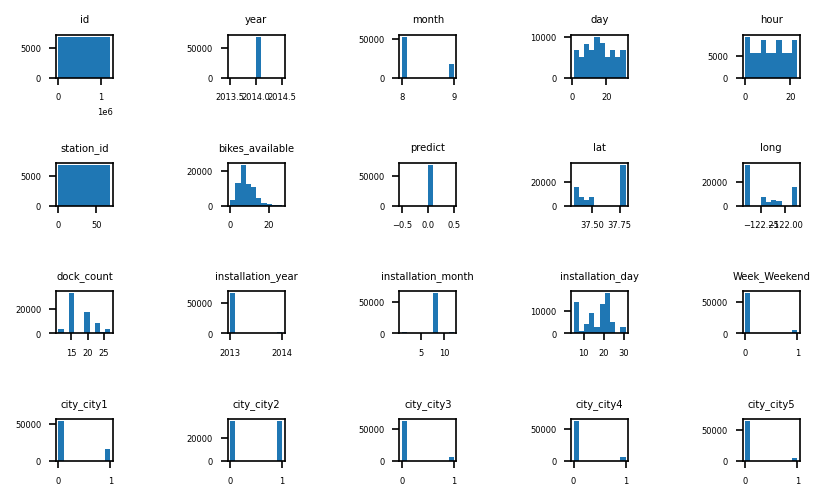

In [7]:
import matplotlib.pyplot as plt
marge_data_list[0].head()

fig = plt.figure(dpi=150)
for i, col in enumerate(marge_data_list[0].columns):
    plt.rcParams["font.size"] = 4
    plt.subplots_adjust(wspace=2, hspace=2)
    # plt.figure(figsize=(4, 4))
    plt.subplot2grid((5, 5), (i//5 ,i%5))
    plt.hist(marge_data_list[0][col])
    plt.title(col)



In [8]:
train_total = []
test_total = []
test_id_list = []

for train in marge_data_list:
    train = train.drop(['id'], axis=1) 
    train_total.append(train)
    columns_list = train.columns.tolist()
print(columns_list)

for test in merge_test_data_list:
    #trainとcustomerを結合
    test_id = test["id"]
    test = test.drop(['id'], axis=1) 
    test_total.append(test)
    test_id_list.append(test_id)

    columns_list = test.columns.tolist()
print(columns_list)


['year', 'month', 'day', 'hour', 'station_id', 'bikes_available', 'predict', 'lat', 'long', 'dock_count', 'installation_year', 'installation_month', 'installation_day', 'Week_Weekend', 'city_city1', 'city_city2', 'city_city3', 'city_city4', 'city_city5']
['year', 'month', 'day', 'hour', 'station_id', 'bikes_available', 'predict', 'lat', 'long', 'dock_count', 'installation_year', 'installation_month', 'installation_day', 'Week_Weekend', 'city_city1', 'city_city2', 'city_city3', 'city_city4', 'city_city5']


In [9]:
train_total[0].info()
# print(merge_data.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69580 entries, 0 to 69579
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                69580 non-null  int64  
 1   month               69580 non-null  int64  
 2   day                 69580 non-null  int64  
 3   hour                69580 non-null  int64  
 4   station_id          69580 non-null  int64  
 5   bikes_available     69580 non-null  float64
 6   predict             69580 non-null  int64  
 7   lat                 69580 non-null  float64
 8   long                69580 non-null  float64
 9   dock_count          69580 non-null  int64  
 10  installation_year   69580 non-null  int32  
 11  installation_month  69580 non-null  int32  
 12  installation_day    69580 non-null  int32  
 13  Week_Weekend        69580 non-null  int64  
 14  city_city1          69580 non-null  int64  
 15  city_city2          69580 non-null  int64  
 16  city

In [10]:
train_total[0].describe()

,year,month,day,hour,station_id,bikes_available,predict,lat,long,dock_count,installation_year,installation_month,installation_day,Week_Weekend,city_city1,city_city2,city_city3,city_city4,city_city5
count,69580.0,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.0,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000
mean,2014.0,8.251509,15.301811,11.384306,34.500000,8.346881,0.0,37.590244,-122.218416,17.657143,2013.042857,7.928571,16.985714,0.071429,0.228571,0.500000,0.100000,0.100000,0.071429
std,0.0,0.433884,8.332649,6.982292,20.205343,3.975875,0.0,0.202015,0.207947,3.981721,0.202536,1.457223,6.994932,0.257541,0.419916,0.500004,0.300002,0.300002,0.257541
min,2014.0,8.000000,1.000000,0.000000,0.000000,0.000000,0.0,37.329730,-122.418950,11.000000,2013.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.0,8.000000,9.000000,5.000000,17.000000,6.000000,0.0,37.389220,-122.400810,15.000000,2013.000000,8.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.0,8.000000,15.000000,11.000000,34.500000,8.000000,0.0,37.631165,-122.312120,15.000000,2013.000000,8.000000,19.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,2014.0,9.000000,22.000000,17.000000,52.000000,11.000000,0.0,37.788450,-122.076710,19.000000,2013.000000,8.000000,22.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2014.0,9.000000,31.000000,23.000000,69.000000,27.000000,0.0,37.804770,-121.877350,27.000000,2014.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train_total[0].head()


,year,month,day,hour,station_id,bikes_available,predict,lat,long,dock_count,installation_year,installation_month,installation_day,Week_Weekend,city_city1,city_city2,city_city3,city_city4,city_city5
0,2014,8,1,0,0,12.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0
1,2014,8,1,1,0,13.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0
2,2014,8,1,2,0,13.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0
3,2014,8,1,3,0,13.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0
4,2014,8,1,4,0,13.0,0,37.32973,-121.90178,27,2013,8,6,0,1,0,0,0,0


In [12]:
# スコア低下したので除外
# # 最小値を0ではなく一番小さい値にする
# tx_amount_min = train_total[train_total.TX_AMOUNT > 0].TX_AMOUNT.min()
# per_terminal_min = train_total[train_total.per_terminal > 0].per_terminal.min()
# per_customer_min = train_total[train_total.per_customer > 0].per_customer.min()
# print(tx_amount_min)
# train_total["TX_AMOUNT"] += tx_amount_min
# train_total["per_terminal"] += per_terminal_min
# train_total["per_customer"] += per_customer_min
# train_total.describe()

In [13]:
# # 対数変換
# log_list = ["x_customer_id","y_customer_id","mean_amount","std_amount","mean_nb_tx_per_day","x_terminal_id","y_terminal_id"]
# fig = plt.figure(dpi=150)
# for i,indent in enumerate(log_list):
#     plt.rcParams["font.size"] = 4
#     plt.subplots_adjust(wspace=2, hspace=2)
#     train_total[indent] = np.log(train_total[indent])
#     plt.subplot2grid((5, 5), (i//5 ,i%5))
#     plt.hist(train_total[indent])
#     plt.title(indent)
# train_total.describe()

In [14]:
test_total[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16100 entries, 0 to 16099
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                16100 non-null  int64  
 1   month               16100 non-null  int64  
 2   day                 16100 non-null  int64  
 3   hour                16100 non-null  int64  
 4   station_id          16100 non-null  int64  
 5   bikes_available     0 non-null      float64
 6   predict             16100 non-null  int64  
 7   lat                 16100 non-null  float64
 8   long                16100 non-null  float64
 9   dock_count          16100 non-null  int64  
 10  installation_year   16100 non-null  int32  
 11  installation_month  16100 non-null  int32  
 12  installation_day    16100 non-null  int32  
 13  Week_Weekend        16100 non-null  int64  
 14  city_city1          16100 non-null  int64  
 15  city_city2          16100 non-null  int64  
 16  city

In [15]:
test_total[0].describe()


,year,month,day,hour,station_id,bikes_available,predict,lat,long,dock_count,installation_year,installation_month,installation_day,Week_Weekend,city_city1,city_city2,city_city3,city_city4,city_city5
count,16100.0,16100.0,16100.000000,16100.000000,16100.000000,0.0,16100.0,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000,16100.000000
mean,2014.0,9.0,16.200000,12.000000,34.500000,NaN,1.0,37.590244,-122.218416,17.657143,2013.042857,7.928571,16.985714,0.071429,0.228571,0.500000,0.100000,0.100000,0.071429
std,0.0,0.0,9.652243,6.633456,20.205825,NaN,0.0,0.202020,0.207952,3.981816,0.202541,1.457258,6.995099,0.257547,0.419926,0.500016,0.300009,0.300009,0.257547
min,2014.0,9.0,1.000000,1.000000,0.000000,NaN,1.0,37.329730,-122.418950,11.000000,2013.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.0,9.0,6.000000,6.000000,17.000000,NaN,1.0,37.389220,-122.400810,15.000000,2013.000000,8.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2014.0,9.0,19.000000,12.000000,34.500000,NaN,1.0,37.631165,-122.312120,15.000000,2013.000000,8.000000,19.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,2014.0,9.0,25.000000,18.000000,52.000000,NaN,1.0,37.788450,-122.076710,19.000000,2013.000000,8.000000,22.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,2014.0,9.0,29.000000,23.000000,69.000000,NaN,1.0,37.804770,-121.877350,27.000000,2014.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# # 最小値を0ではなく一番小さい値にする
# tx_amount_min = test_total[test_total.TX_AMOUNT > 0].TX_AMOUNT.min()
# per_terminal_min = test_total[test_total.per_terminal > 0].per_terminal.min()
# per_customer_min = test_total[test_total.per_customer > 0].per_customer.min()
# print(tx_amount_min)
# test_total["TX_AMOUNT"] += tx_amount_min
# test_total["per_terminal"] += per_terminal_min
# test_total["per_customer"] += per_customer_min
# test_total.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69580 entries, 0 to 69579
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                69580 non-null  int64  
 1   month               69580 non-null  int64  
 2   day                 69580 non-null  int64  
 3   hour                69580 non-null  int64  
 4   station_id          69580 non-null  int64  
 5   bikes_available     69580 non-null  float64
 6   predict             69580 non-null  int64  
 7   lat                 69580 non-null  float64
 8   long                69580 non-null  float64
 9   dock_count          69580 non-null  int64  
 10  installation_year   69580 non-null  int32  
 11  installation_month  69580 non-null  int32  
 12  installation_day    69580 non-null  int32  
 13  Week_Weekend        69580 non-null  int64  
 14  city_city1          69580 non-null  int64  
 15  city_city2          69580 non-null  int64  
 16  city

/home/hayato/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/hayato/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


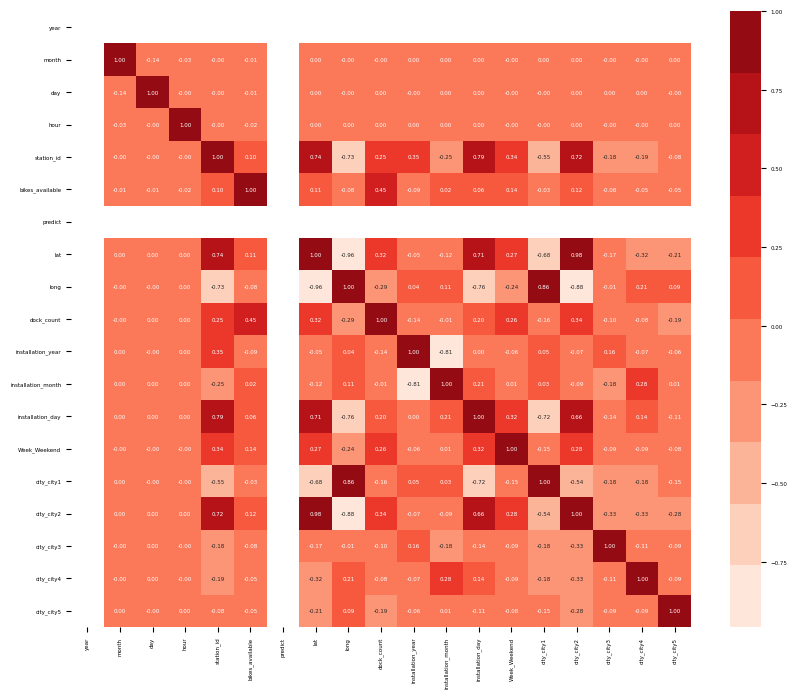

In [17]:
# 情報量が多く処理が完了しないので8月までのデータでヒートマップ算出する
import seaborn as sns
%matplotlib inline
train_total[0].info()
corrs = np.corrcoef(train_total[0], rowvar=False)
fig,ax = plt.subplots(figsize=(10,8))

sns.heatmap(corrs, cmap=sns.color_palette('Reds', 10), annot=True,
            fmt='.2f', xticklabels=train_total[0].columns.tolist(), yticklabels=train_total[0].columns.tolist())
# input_features = ["x_customer_id","y_customer_id","x_terminal_id","y_terminal_id","distance",'TX_AMOUNT',"TX_AMOUNT-mean","mean_amount","std_amount","mean_nb_tx_per_day"]
# sns.heatmap(train_total[input_features],vmax=1, vmin=-1, center=0)
plt.savefig("heatmap.png")

In [18]:
###ここまでできた

y = []
for train in train_total:
    y.append(train['bikes_available'])
    train.drop('bikes_available', axis=1, inplace=True)
    train.drop('predict', axis=1, inplace=True)
    print(train.head())

for test in test_total:
    # bikes_availableは目的変数なのでテストデータには存在しない
    test.drop('bikes_available', axis=1, inplace=True)
    test.drop('predict', axis=1, inplace=True)
    print(test.head())


   year  month  day  hour  station_id       lat       long  dock_count   
0  2014      8    1     0           0  37.32973 -121.90178          27  \
1  2014      8    1     1           0  37.32973 -121.90178          27   
2  2014      8    1     2           0  37.32973 -121.90178          27   
3  2014      8    1     3           0  37.32973 -121.90178          27   
4  2014      8    1     4           0  37.32973 -121.90178          27   

   installation_year  installation_month  installation_day  Week_Weekend   
0               2013                   8                 6             0  \
1               2013                   8                 6             0   
2               2013                   8                 6             0   
3               2013                   8                 6             0   
4               2013                   8                 6             0   

   city_city1  city_city2  city_city3  city_city4  city_city5  
0           1           0         

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def calc_accuracy(y_pred, y_true):
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True

def calc_precision(y_pred, y_true):
    metric = precision_score(y_true, y_pred)
    return 'precison', metric, True

def calc_recall(y_pred, y_true):
    metric = recall_score(y_true, y_pred)
    return 'recall', metric, True

def calc_fscore(fscores):
    metric = np.max(fscores)
    return 'fscore', metric, True

def calc_auc(y_pred, y_true):
    metric = roc_auc_score(y_true, y_pred)
    return 'auc', metric, True

def calc_prauc(y_pred, y_true):
    metric = average_precision_score(y_true, y_pred)
    return 'prauc', metric, True

In [20]:
def acquire_custom_metircs(preds ,data):
    # precisions, recalls, thresholds = precision_recall_curve(data.get_label(), preds, pos_label=1)
    # thresholds = np.append(thresholds, 1)
    # fscores = 2 * precisions * recalls / (precisions + recalls)
    # threshold_max_fscore = thresholds[np.argmax(fscores)]

    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)

    # return [
    #     calc_accuracy(y_pred, y_true),  ＃ Accuracy
    #     calc_precision(y_pred, y_true),  ＃ Precision
    #     calc_recall(y_pred, y_true),  # Recall
    #     calc_fscore(fscores),  # F1 score
    #     calc_auc(y_pred, y_true),  # ROC AUC
    #     calc_prauc(y_pred, y_true)  # PR AUC
    # ]
    score = calc_precision(y_pred, y_true), # Precision 
    # print("precision")
    # print(score[0])
    return score[0]

In [23]:
# 上のグリッドサーチで見つけたベストパラメータで全データでの学習、推論を行い結果を算出する。
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     # 'metric': 'rmse',
#     'metric': 'binary_logloss',
#     # 'metric': 'auc', # AUCでもいい
    
#     "seed":31,
#     'random_state': 42,
#     # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
#     'verbose' : -1,
#     "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
#     "learning_rate": 0.005, #学習率
#     "num_leaves":31,
#     "max_depth":12,
#     "min_data_in_leaf":20,
#     "bagging_fraction":0.8,
#     "bagging_freq":1,
# }
# グリッドサーチは時間かかって終わらないのでそのままにする
# if len(best_params) == 0:
# best_params = params

# 学習データと検証データの分割
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
X_train = []
X_valid = []
y_train = []
y_valid = []
train_total[0].info()
for train_data, y_data in zip(train_total,y):
    train, valid, ytrain, yvalid = train_test_split(train_data, y_data, test_size=0.2, random_state=42)
    X_train.append(train)
    X_valid.append(valid)
    y_train.append(ytrain)
    y_valid.append(yvalid)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69580 entries, 0 to 69579
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                69580 non-null  int64  
 1   month               69580 non-null  int64  
 2   day                 69580 non-null  int64  
 3   hour                69580 non-null  int64  
 4   station_id          69580 non-null  int64  
 5   lat                 69580 non-null  float64
 6   long                69580 non-null  float64
 7   dock_count          69580 non-null  int64  
 8   installation_year   69580 non-null  int32  
 9   installation_month  69580 non-null  int32  
 10  installation_day    69580 non-null  int32  
 11  Week_Weekend        69580 non-null  int64  
 12  city_city1          69580 non-null  int64  
 13  city_city2          69580 non-null  int64  
 14  city_city3          69580 non-null  int64  
 15  city_city4          69580 non-null  int64  
 16  city

In [ ]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

In [ ]:
# ## グリッドサーチ
# import lightgbm as lgb

# # https://pythonandai.com/grid-search/
# from sklearn.model_selection import GridSearchCV
# learning_rate = [0.001]
# num_leaves = [31]
# max_depth = [12]
# min_data_in_leaf = [20]
# params = {
#     'boosting_type': ['gbdt'],
#     'objective': ['binary'],
#     # 'metric': 'rmse',
#     'metric': ['binary_logloss',"auc"],
#     # 'metric': 'auc', # AUCでもいい
    
#     # "seed":[31],
#     # 'random_state': [42],
#     # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # 'verbose' : [-1],
#     "num_iterations":[10000], # early stopping で止まるため大きめに設定しておけばよい
    
#     # 以下のパラメータを調整対象とする
#     "learning_rate": learning_rate, #学習率
#     "num_leaves":num_leaves,
#     "max_depth":max_depth,
#     "min_data_in_leaf":min_data_in_leaf,
#     # "bagging_fraction":[0.8],
#     # "bagging_freq":[1],
# }

# lgbm = lgb.LGBMClassifier(random_state=0)
# gcv = GridSearchCV(lgbm, params, cv=3, scoring='precision', return_train_score=True)
# gcv.fit(X_train, y_train)

In [ ]:
# # グリッドサーチの結果から、学習データとテストデータのスコアを取得
# train_score = gcv.cv_results_["mean_train_score"]
# test_score = gcv.cv_results_["mean_test_score"]

# # matplotlib.pyplotを省略名pltとしてインポート 
# import matplotlib.pyplot as plt
# plt.rcParams["font.size"] = 14

# # 学習データのスコアをプロット
# plt.plot(num_leaves, train_score, label="train_score")

# # テストデータのスコアをプロット
# plt.plot(num_leaves, test_score, label="test_score")

# # グラフにタイトルを追加
# plt.title('train_score vs test_score')

# # グラフのx軸に名前を追加
# plt.xlabel('learning_rate')

# # グラフのy軸に名前を追加
# plt.ylabel('precision')

# # 凡例の表示
# plt.legend()

# # グラフの表示
# plt.show()

In [ ]:
# # グリッドサーチの結果から、最適なパラメータを表示
# print("Best parameters: ", gcv.best_params_)

# # 最適なパラメータで学習したモデルを取得
# optimal_model = gcv.best_estimator_

# # 最適なモデルを用いて、評価用データの予測を行う
# predicted_values = optimal_model.predict_proba(test_total)[:,1]


In [ ]:
# from sklearn import metrics
# # 予測結果を用いてAUCを計算
# auc_score = roc_auc_score(y_test_true, predicted_values)

# predicted_values_int = np.where(predicted_values > 0.5, 1, 0)
# precision_score = metrics.precision_score(y_true=y_test_true, y_pred=predicted_values_int)
# recall_score = metrics.recall_score(y_true=y_test_true, y_pred=predicted_values_int)
# print(f'precision_score={precision_score}')
# print(f'recall_score={recall_score}')
# print(f'sum_score={recall_score+precision_score}')


# # 計算したAUCを表示
# print("AUC Score: ", auc_score)
# import seaborn as sns
# from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
#    roc_curve, recall_score, classification_report, f1_score,
#    precision_recall_fscore_support)
# conf_matrix = confusion_matrix(y_test_true, predicted_values_int)
# plt.figure(figsize=(5, 5))
# sns.heatmap(conf_matrix, xticklabels=["Normal","Fraund"], yticklabels=["Normal","Fraund"], annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show()
# # precision_score = precision_score(y_true=y_test_true, y_pred=predicted_values_int)
# print(f'precision_score={precision_score}')

In [ ]:
# from sklearn import metrics

# precision, recall, thresholds = metrics.precision_recall_curve(y_test_true, predicted_values)

# auc = metrics.auc(recall, precision)
# print(auc)

# plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
# plt.legend()
# plt.title('PR curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.grid(True)
# plt.show()

In [ ]:
# y_pred = predicted_values
# y_pred_label_normal_test = y_pred[y_test_true==0]
# y_pred_label_fraud_test = y_pred[y_test_true==1]
# print(len(y_pred_label_normal_test))
# print(len(y_pred_label_fraud_test))

In [ ]:

# f, (ax) = plt.subplots()
# f.suptitle('Prediction hist Test')


# bins = 50

# ax.hist(y_pred_label_normal_test, bins = bins)
# ax.set_title('normal')

# ax.hist(y_pred_label_fraud_test, bins = bins)
# ax.set_title('fraud')

# plt.xlabel('test pred')
# plt.ylabel('Frequencey')
# plt.xlim((0, 1))
# plt.yscale('log')
# plt.text(0.05, 0.92, 'normal  = Blue',transform = ax.transAxes, fontsize = 14)
# plt.text(0.05, 0.86, 'abnormal = Orange',transform = ax.transAxes, fontsize = 14)
# plt.show();

In [ ]:
# y_pred_train = optimal_model.predict_proba(train_total)[:,1]
# y_pred_label_normal = y_pred_train[y==0]
# y_pred_label_fraud = y_pred_train[y==1]


In [ ]:

# f, (ax) = plt.subplots()
# f.suptitle('Prediction hist Train')

# bins = 50

# ax.hist(y_pred_label_normal, bins = bins)
# ax.set_title('normal')

# ax.hist(y_pred_label_fraud, bins = bins)
# ax.set_title('fraud')

# plt.xlabel('train pred')
# plt.ylabel('Frequencey')
# plt.xlim((0, 1))
# plt.yscale('log')
# plt.text(0.05, 0.92, 'normal  = Blue',transform = ax.transAxes, fontsize = 14)
# plt.text(0.05, 0.86, 'abnormal = Orange',transform = ax.transAxes, fontsize = 14)
# plt.show();

In [ ]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

# finish

In [ ]:
# 上の方法だとうまく重みづけ学習できないので、別ページを参考に実践する
# https://an-engineer-note.com/?p=312#toc3
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
# dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
# dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
dtrain_list = []
dvalid_list = []
for train, valid, ytrain, yvalid in zip(X_train, X_valid, y_train, y_valid):
    dtrain = lgb.Dataset(train, label=ytrain, weight=compute_sample_weight(class_weight='balanced', y=ytrain).astype('float32'))
    dvalid = lgb.Dataset(valid, label=yvalid, reference=dtrain)
    dtrain_list.append(dtrain)
    dvalid_list.append(dvalid)
    # https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
    # fobj=fobjというハイパラもある？
    print(compute_sample_weight(class_weight='balanced', y=ytrain).astype('float32'))

[1.0015539  0.99845093 0.99845093 ... 0.99845093 1.0015539  0.99845093]
[1. 1. 1. ... 1. 1. 1.]


In [ ]:
learning_rate = 0.001
num_leaves = 31
max_depth = 12
min_data_in_leaf = 20
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    # 'metric': 'rmse',
    'metric': 'binary_logloss',
    # 'metric': 'auc', # AUCでもいい
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [ ]:
def gbm_train(dtrain,dvalid):
     #学習
     # 以下を参考にearly stoppingを10で設定
     # https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
     # ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
     # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

     verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
     evaluation_results = {} 
     import time
     starttime = time.time()
     # best_params = gcv.best_params_
     best_params = params

     gbm = lgb.train(best_params,
                    dtrain,
                    #categorical_feature=categorical_features,
                    valid_sets=[dtrain,dvalid],
                    valid_names=['train', 'valid'],     
                    num_boost_round = 10000,
                    # feval=acquire_custom_metircs, 
                    callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                   verbose=True), # early_stopping用コールバック関数
                              lgb.log_evaluation(verbose_eval),
                              lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                    )
     end_time = time.time() - starttime
     print("elapsed time is {}".format(end_time))
     return gbm, evaluation_results


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4196, number of negative: 4183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 8379, number of used features: 14
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[6329]	train's binary_logloss: 0.0662658	valid's binary_logloss: 0.102911


In [ ]:
def training_viz(evaluation_results):
    # 学習過程の可視化
    plt.rcParams["font.size"] = 12
    plt.plot(evaluation_results['train']['binary_logloss'], label='train')
    plt.plot(evaluation_results['valid']['binary_logloss'], label='valid')
    plt.ylabel('binary_loglosse')
    plt.xlabel('Boosting round')
    plt.title('Training performance')
    plt.legend()
    plt.show()

In [ ]:
# 12個分のデータをfor文で回す
gbm_list = []
evaluation_results_list = []
for dtrain, dvalid in zip(dtrain_list,dvalid_list):
    gbm, evaluation_results = gbm_train(dtrain,dvalid)
    gbm_list.append(gbm)
    evaluation_results_list.append(evaluation_results)
    training_viz(evaluation_results)


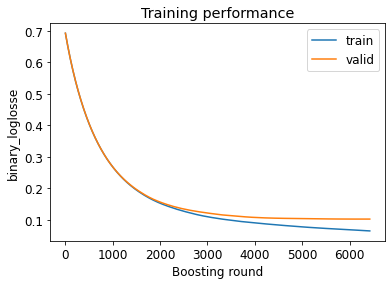

In [ ]:
y_pred = gbm.predict(test_total)

In [ ]:
y_pred_train = gbm.predict(X_valid)
y_pred_label_normal = y_pred_train[y_valid==0]
y_pred_label_fraud = y_pred_train[y_valid==1]

In [ ]:
X_valid.describe()

In [ ]:
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_label_normal, bins = bins)
ax.set_title('normal')

ax.hist(y_pred_label_fraud, bins = bins)
ax.set_title('fraud')

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.92, 'normal  = Blue',transform = ax.transAxes, fontsize = 14)
plt.text(0.05, 0.86, 'abnormal = Orange',transform = ax.transAxes, fontsize = 14)
plt.show();

In [ ]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_train)
auc = metrics.auc(fpr, tpr)
print(auc)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.plot(np.linspace(1, 0, len(fpr)), np.linspace(1, 0, len(fpr)), label='Random ROC curve (area = %.2f)'%0.5, linestyle = '--', color = 'gray')

plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [ ]:
import os
import datetime
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
precision_score = metrics.precision_score(y_true=y_valid, y_pred=y_pred_int)
recall_score = metrics.recall_score(y_true=y_valid, y_pred=y_pred_int)
accuracy_score = metrics.accuracy_score(y_true=y_valid, y_pred=y_pred_int)

print(f'precision_score={precision_score}')
print(f'recall_score={recall_score}')
print(f'accuracy_score={accuracy_score}')

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=["Normal","Abnormal"], yticklabels=["Normal","Abnormal"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

In [ ]:
# y_pred = gbm.predict(test_total)
precision, recall, thresholds = metrics.precision_recall_curve(y_valid, y_pred_train)

auc = metrics.auc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

In [ ]:
# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_train)
 
# AUCを計算
roc_auc = metrics.auc(fpr, tpr)
 
# ROC曲線をプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred = np.where(y_pred >Dicision_threshould, 1, 0)
y_pred = pd.DataFrame(y_pred)
y_pred.head()

In [ ]:
test_id.head()

In [ ]:
# make submission file
submission_pd = pd.concat([test_id, y_pred], axis=1)
submission_pd.head()
submission_pd.to_csv("submission.csv", index = False, header = False)

In [ ]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0
y_pred_train_ansamble = y_pred_train 


# スコア(RMSE)算出
y_pred_int = np.where(y_pred_train_ansamble > Dicision_threshould, 1, 0)
precision_score = metrics.precision_score(y_true=y_valid, y_pred=y_pred_int)
recall_score = metrics.recall_score(y_true=y_valid, y_pred=y_pred_int)
accuracy_score = metrics.accuracy_score(y_true=y_valid, y_pred=y_pred_int)

print(f'precision_score={precision_score}')
print(f'recall_score={recall_score}')
print(f'accuracy_score={accuracy_score}')
plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=["Normal","Abnormal"], yticklabels=["Normal","Abnormal"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

# make submission file
submission_pd = pd.concat([test_id, y_pred_train_ansamble], axis=1)
submission_pd.head()
submission_pd.to_csv("submission_ansamble.csv", index = False, header = False)